In [1]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage
from langchain_core.documents import Document

class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    question_type: str  # "explanation" or "code"
    processed_output: str


In [2]:
from langchain_ollama import ChatOllama
from langchain.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = PyPDFLoader("/home/balajip/PyTorch_tutor/Deep-Learning-with-PyTorch.pdf")
docs = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
documents = splitter.split_documents(docs)

embedding_model = OllamaEmbeddings(
    model = "all-minilm:22m"
)
vectorstore = FAISS.from_documents(documents, embedding_model)
retriever = vectorstore.as_retriever()


In [3]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model = "llama3.1:latest",
    temperature = 0
)

In [4]:
def question_classifier(state: AgentState) -> AgentState:
    last_message = state["messages"][-1].content.lower()
    if "code" in last_message or "implement" in last_message:
        state["question_type"] = "code"
    else:
        state["question_type"] = "explanation"
    return state


In [5]:
from langchain.retrievers import ContextualCompressionRetriever

def retrieve_docs(state: AgentState) -> AgentState:
    question = state["messages"][-1].content
    retrieved_docs = retriever.get_relevant_documents(question)
    state["documents"] = retrieved_docs
    return state


In [6]:
def generate_explanation(state: AgentState) -> AgentState:
    from langchain_core.prompts import ChatPromptTemplate
    prompt = ChatPromptTemplate.from_template(
        "Explain the following PyTorch topic clearly:\n{context}\n\nUser Question:\n{question}"
    )
    context = "\n".join([doc.page_content for doc in state["documents"]])
    question = state["messages"][-1].content
    full_prompt = prompt.format(context=context, question=question)
    
    output = llm.invoke(full_prompt)
    state["processed_output"] = output.content
    return state


In [7]:
def generate_code(state: AgentState) -> AgentState:
    from langchain_core.prompts import ChatPromptTemplate
    prompt = ChatPromptTemplate.from_template(
        "Write working PyTorch code based on the user request:\n{context}\n\nQuestion:\n{question}"
    )
    context = "\n".join([doc.page_content for doc in state["documents"]])
    question = state["messages"][-1].content
    full_prompt = prompt.format(context=context, question=question)

    output = llm.invoke(full_prompt)
    state["processed_output"] = output.content
    return state


In [8]:
def generate_code(state: AgentState) -> AgentState:
    from langchain_core.prompts import ChatPromptTemplate
    prompt = ChatPromptTemplate.from_template(
        "Write working PyTorch code based on the user request:\n{context}\n\nQuestion:\n{question}"
    )
    context = "\n".join([doc.page_content for doc in state["documents"]])
    question = state["messages"][-1].content
    full_prompt = prompt.format(context=context, question=question)

    output = llm.invoke(full_prompt)
    state["processed_output"] = output.content
    return state


In [9]:
def router(state: AgentState) -> str:
    return "generate_code" if state["question_type"] == "code" else "generate_explanation"


In [10]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)
graph.add_node("question_classifier", question_classifier)
graph.add_node("retrieve_docs", retrieve_docs)
graph.add_node("generate_explanation", generate_explanation)
graph.add_node("generate_code", generate_code)

# Step 1: classify → retrieve_docs
graph.add_edge("question_classifier", "retrieve_docs")

# Step 2: conditional routing after retrieving
graph.add_conditional_edges(
    "retrieve_docs",
     router,
     {
         "explanation": "generate_explanation",
         "code" : "generate_code"
     }
     )

# Final: both code and explanation → END
graph.add_edge("generate_code", END)
graph.add_edge("generate_explanation", END)

graph.set_entry_point("question_classifier")

app = graph.compile()


In [12]:
from langchain_groq import ChatGroq
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate

In [13]:
class AgentState(TypedDict):
    messages: List[BaseMessage]
    question_type: str
    processed_output: str

# === LLM Setup ===
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)

# === Nodes ===
def generate_greeting(state: AgentState) -> AgentState:
    prompt = (
        "You are PyTutor, a friendly AI tutor who specializes in PyTorch and Python. "
        "A user has greeted you (e.g., said hello or hi). Respond with a warm, friendly greeting. "
        "Avoid answering unrelated questions. Stay in character as a tutor."
    )
    response = llm.invoke(prompt)
    state["processed_output"] = response.content
    return state

def question_classifier(state: AgentState) -> AgentState:
    msg = state["messages"][-1].content.lower()
    greetings = ["hello", "hi", "hey", "greetings"]

    if any(greet in msg for greet in greetings):
        state["question_type"] = "greeting"
    elif "code" in msg or "implement" in msg or "error" in msg or "fix" in msg:
        state["question_type"] = "code"
    else:
        state["question_type"] = "explanation"
    return state


def generate_explanation(state: AgentState) -> AgentState:
    chat_history = "\n".join([f"User: {m.content}" if isinstance(m, HumanMessage) else f"Tutor: {m.content}" for m in state["messages"] if isinstance(m, (HumanMessage, AIMessage))])
    question = state["messages"][-1].content
    prompt = ChatPromptTemplate.from_template(
    "You are PyTutor, a helpful tutor for PyTorch and Python. Here's the conversation so far:\n{history}\n\nCurrent Question:\n{question}\n\nPlease respond accordingly."
    )
    full_prompt = prompt.format(history=chat_history, question=question)

    response = llm.invoke(full_prompt)
    state["processed_output"] = response.content
    return state

def generate_code(state: AgentState) -> AgentState:
    chat_history = "\n".join([
        f"User: {m.content}" if isinstance(m, HumanMessage)
        else f"Tutor: {m.content}"
        for m in state["messages"] if isinstance(m, (HumanMessage, AIMessage))
    ])
    question = state["messages"][-1].content

    fix_keywords = ["fix", "error", "bug", "issue", "debug"]
    is_fix_request = any(word in question.lower() for word in fix_keywords)

    if is_fix_request:
        prompt = ChatPromptTemplate.from_template(
            "You are PyTutor, a Python expert. Based on this conversation:\n{history}\n\n"
            "The user is asking you to help fix some buggy code or error message:\n{question}\n\n"
            "Please provide a corrected version of the code with explanation if needed."
        )
    else:
        prompt = ChatPromptTemplate.from_template(
            "You are PyTutor, a helpful tutor for PyTorch and Python. Here's the conversation so far:\n{history}\n\n"
            "Current Question:\n{question}\n\nPlease respond accordingly."
        )

    full_prompt = prompt.format(history=chat_history, question=question)
    response = llm.invoke(full_prompt)
    state["processed_output"] = response.content
    return state


def router(state: AgentState) -> str:
    return "code" if state["question_type"] == "code" else "explanation"

def check_relevance(state: AgentState) -> AgentState:
    question = state["messages"][-1].content.lower()

    # Check if it's a greeting
    greetings = ["hello", "hi", "hey", "greetings"]
    if any(greet in question for greet in greetings):
        state["question_type"] = "greeting"
        return state

    # Check if it's relevant
    prompt = (
        "Is the following question about PyTorch or Python programming?\n"
        f"Question: {question}\n\n"
        "Reply with only 'yes' or 'no'."
    )
    response = llm.invoke(prompt).content.strip().lower()

    if "yes" in response:
        state["question_type"] = "relevant"
    else:
        state["question_type"] = "irrelevant"
        state["processed_output"] = (
            "I'm PyTutor, a tutor dedicated to helping with PyTorch and Python-related questions only. "
            "Please ask something in that area so I can assist you better."
        )
    return state

def relevance_router(state: AgentState) -> str:
    if state["question_type"] == "relevant":
        return "question_classifier"
    elif state["question_type"] == "greeting":
        return "generate_greeting"
    else:
        return "end_irrelevant"


# === Graph Setup ===
graph = StateGraph(AgentState)

graph.add_node("check_relevance", check_relevance)
graph.add_node("question_classifier", question_classifier)
graph.add_node("generate_explanation", generate_explanation)
graph.add_node("generate_code", generate_code)
graph.add_node("generate_greeting", generate_greeting)

# Node to handle irrelevant questions (just return final message)
graph.add_node("end_irrelevant", lambda state: state)

graph.add_conditional_edges(
    "check_relevance", relevance_router, {
        "question_classifier": "question_classifier",
        "end_irrelevant": "end_irrelevant"
    }
)

graph.add_conditional_edges(
    "question_classifier", router, {
        "code": "generate_code",
        "explanation": "generate_explanation",
        "greeting": "generate_greeting"
    }
)

graph.add_edge("generate_code", END)
graph.add_edge("generate_explanation", END)
graph.add_edge("end_irrelevant", END)
graph.add_edge("generate_greeting", END)

graph.set_entry_point("check_relevance")
app = graph.compile()


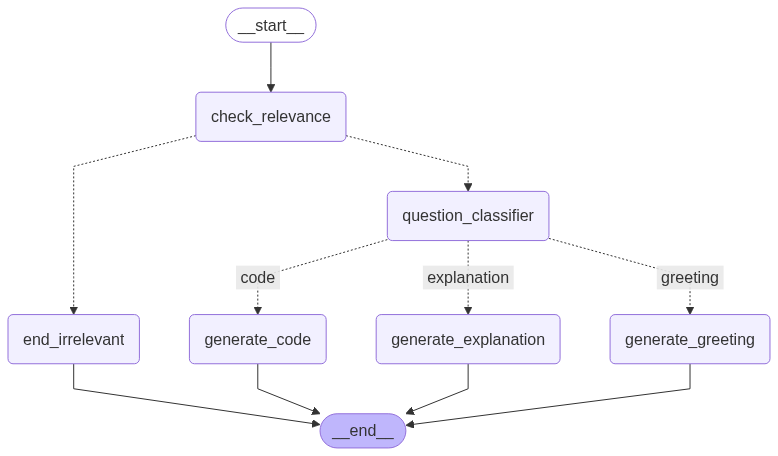

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)